In [1]:
import numpy as np
import matplotlib.pyplot as plt

import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
# config.GPU = True
# ===============================================
import pickle
from trainer import Trainer
from optimizer import Adam

from util import *
from dataset import ptb

# Chapter 6 게이트가 추가된 RNN

요즘은 앞 장의 단순한 RNN 대신 LSTM이나 GRU라는 계층이 주로 사용된다. LSTM과 GRU에는 '게이트'라는 구조가 더해져 있어서 시계열 데이터의 장기 의존 관계를 학습할 수 있다.

이번 장에는 다음 사항들을 알아볼 예정이다. 
- 기존 RNN의 문제점
- '게이트가 추가된 RNN': LSTM, GRU
- LSTM의 구조를 살펴보고, '장기 기억'을 가능하게 하는 메커니즘 이해
- LSTM을 이용한 언어 모델을 만들기

## 6.1 RNN의 문제점

기존 RNN에서 BPTT를 이용한 학습을 진행하면 vanishing & exploding gradient 문제가 발생한다. 이 때문에 기존 RNN에서는 시계열 데이터의 장기 의존 관계를 학습하기 어렵다.

### 6.1.1 RNN 복습

RNN 계층의 순환 경로를 펼치면 다음 그림과 같다.

<img src="./deep_learning_2_images/fig 6-1.png" width="70%">

RNN 계층은 시계열 데이터 $\mathbf{x}_t$를 입력하면 $\mathbf{h}_t$를 출력한다. $\mathbf{h}_t$는 RNN 계층의 hidden state라고도 하며, 과거 정보를 저장한다.

RNN은 바로 이전 시각의 hidden state를 이용하므로, 과거 정보를 계승할 수 있다. 이를 계산 그래프로 나타내면 다음과 같다. 

<img src="./deep_learning_2_images/fig 6-2.png" width="60%">

### 6.1.2 기울기 소실 또는 기울기 폭발

RNNLM을 이용해 다음 문제를 푸는 상황을 가정해보자. 

<img src="./deep_learning_2_images/fig 6-3.png" width="60%">

"?"에 들어갈 단어는 "Tom"이다. RNNLM이 이 문제를 풀기 위해서는 "Tom이 방에서 TV를 보고 있다"와 "Mary가 Tom의 방에 들어왔다"라는 정보를 RNN 계층의 hidden state에 인코딩해 기억하고 있어야 한다

이 정보를 학습하는 과정을 RNNLM의 흐름으로 나타내면 다음과 같다. 

<img src="./deep_learning_2_images/fig 6-4.png" width="60%">

RNN 계층을 학습할 때, 기울기 정보를 과거로 보내면서 장기 의존 관계를 학습한다. 하지만 중간에 이 기울기가 없어지면 가중치 매개변수는 갱신되지 않는다. 단순한 RNN 계층에서는 과거로 갈수록 vanishing gradient 또는 exploding gradient 문제가 발생한다.

### 6.1.3 기울기 소실과 기울기 폭발의 원인

RNN에서 vanishing gradient가 발생하는 원인 중 하나는 활성화 함수로 $\tanh$를 사용하기 때문이다. $\tanh$의 미분값은 모두 1.0 이하이고, $x=0$에서 멀어질수록 그 값은 작아진다. 따라서 BPTT 과정에서 $\tanh$를 지날 때마다 기울기가 계속 작아진다. 

다른 이유는 MatMul의 역전파 과정이다. BPTT 과정에서 가중치 매개변수는 다음과 같은 학습 과정을 거친다.

<img src="./deep_learning_2_images/fig 6-7.png" width="70%">

다음 코드를 통해 $\mathbf{W}_h$에 따른 기울기의 변화를 파악해볼 수 있다.

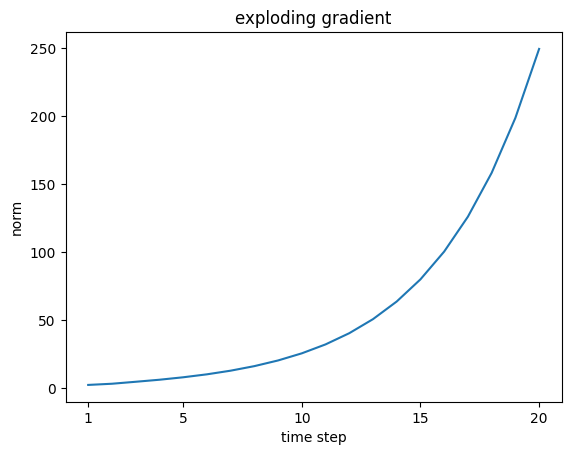

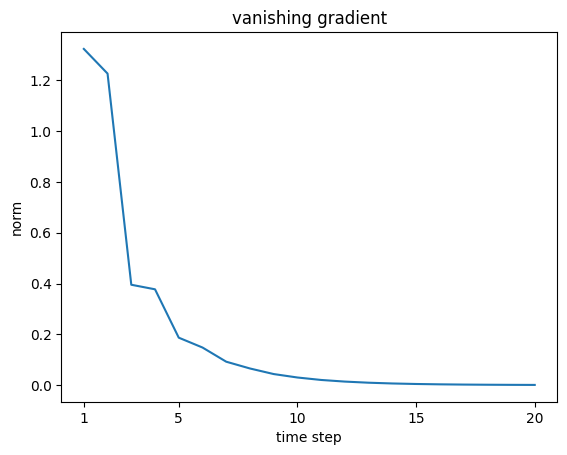

In [2]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch06/rnn_gradient_graph.py
License: MIT License
Accessed: 2024-11-22

Modified to work on jupyter notebook
------------------------------------------------------------
"""

N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh_e = np.ones((N, H))
dh_v = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

Wh_e = np.random.randn(H, H)
Wh_v = np.random.randn(H, H) * 0.5

norm_e_list = []
norm_v_list = []
for t in range(T):
    # exploding gradient
    dh_e = np.dot(dh_e, Wh_e.T)
    norm_e = np.sqrt(np.sum(dh_e**2)) / N
    norm_e_list.append(norm_e)

    # vanishing gradient
    dh_v = np.dot(dh_v, Wh_v.T)
    norm_v = np.sqrt(np.sum(dh_v**2)) / N
    norm_v_list.append(norm_v)

# plot exploding gradient
plt.plot(np.arange(len(norm_e_list)), norm_e_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.title('exploding gradient')
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

# plot vanishing gradient
plt.cla()
plt.plot(np.arange(len(norm_v_list)), norm_v_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.title('vanishing gradient')
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

이번 경우는 행렬의 '특잇값'에 따라 exploding gradient나 vanishing gradient가 발생한다. 행렬의 '특잇값' 중 최댓값이 1보다 큰지 작은지를 보면 기울기의 변화를 예측할 수 있다. 

> 행렬의 특잇값은 SVD를 통해 얻을 수 있다.

### 6.1.4 기울기 폭발 대책

전통적으로는 기울기 폭발을 **기울기 클리핑(gradient clipping)**이라는 기법으로 대처해왔다. 기울기 클리핑은 기울기가 특정 threshold보다 커질 때, 기울기 값을 조절하는 기법을 의미한다.

기울기 클리핑은 다음과 같이 코드로 구현할 수 있다.

In [3]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch06/clip_grads.py
License: MIT License
Accessed: 2024-11-22

Modified to work on jupyter notebook
------------------------------------------------------------
"""


# coding: utf-8
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0          # threshold


def clip_grads(grads, max_norm):
    # gradient의 L2 norm을 구하는 과정
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    # gradient의 norm이 threshold보다 커지면, clipping 수행
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [2.83525082 6.93137918 4.40453718 1.56867738 5.44649018 7.80314765
 3.06363532 2.21957884 3.87971258]
after: [0.54849516 1.34091414 0.85208239 0.30346943 1.05365404 1.50956263
 0.59267742 0.42938996 0.75055213]


## 6.2 기울기 소실과 LSTM

vanishing gradient 문제를 해결하려면 RNN 계층을 뜯어 고쳐야 한다. 그 중 하나가 '게이트가 추가된 RNN'이다. 이번 장에서는 LSTM에 대해 다뤄보고, LSTM이 vanishing gradient 문제를 만들지 않는다는 점을 알아본다.

### 6.2.1 LSTM의 인터페이스

앞으로는 그림의 복잡함을 피하고자, 다음과 같이 계산 그래프를 단순화해서 그릴 예정이다. tanh 박스 안에 MatMul, 편향, tanh 노드 등이 들어있다.

<img src="./deep_learning_2_images/fig 6-10.png" width="70%">

LSTM은 RNN에 $\mathbf{c}$가 추가되었다. $\mathbf{c}$는 **기억 셀 (memory cell)** 이라고 부르며, 데이터를 LSTM 계층 내부에서만 주고받고, 다른 계층으로는 출력하지 않는다. LSTM에서도 hidden state $\mathbf{h}$는 외부로 출력된다.

<img src="./deep_learning_2_images/fig 6-11.png" width="70%">

### 6.2.2 LSTM 계층 조립하기

<img src="./deep_learning_2_images/fig 6-12.png" width="60%">

LSTM의 $\mathbf{c}_t$에는 과거에서부터 시각 t까지 필요한 모든 정보가 저장되어 있다. 외부 계층에는 $\mathbf{c}_t$를 $\tanh$에 통과시킨 값을 hidden state $\mathbf{h}_t$로 출력한다.

또한, LSTM에는 게이트라는 구조도 있다. 게이트는 데이터를 얼마나 보낼 지를 0.0부터 1.0 사이의 실수로 지정해 데이터의 흐름을 조절한다. '게이트를 얼마나 열까' 정보도 데이터로부터 자동으로 학습된다. 게이트의 열림 상태는 시그모이드 함수를 이용해 보통 구한다.

<img src="./deep_learning_2_images/fig 6-14.png" width="70%">

### 6.2.3 output 게이트

이번 장에서는 hidden state $\mathbf{h}_t=\tanh{\mathbf{c}_t}$의 각 원소에 대해 '그것이 다음 시각의 hidden state에 얼마나 중요한가'를 조정하는 **output 게이트에 다룬다**

output 게이트의 열림 상태는 입력 $\mathbf{x}_t$와 이전 상태 $\mathbf{h}_{t-1}$로부터 구한다. 식은 다음과 같다.

$$
\mathbf{o}=\bm{\sigma}(\mathbf{x}_t \mathbf{W}_{\mathbf{x}}^{(\mathbf{o})} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(\mathbf{o})} + \mathbf{b}^{(\mathbf{o})})
$$

여기서 $\sigma()$는 시그모이드 함수이다. 

위 식에서 구한 $\mathbf{o}$와 $\tanh{(\mathbf{c}_t)}$의 원소별 곱을 통해 hidden state $\mathbf{h}_t$를 구한다. 지금까지 구현을 계산 그래프로 나타내면 다음과 같다. 

<img src="./deep_learning_2_images/fig 6-15.png" width="60%">

output gate에서 수행하는 계산을 위 계산 그래프에서 $\bm{\sigma}$로 표현했다. 여기서 $\mathbf{o}$와 $\tanh{(\mathbf{c}_t)}$의 원소별 곱이 나오는데, 원소별 곱을 **아다마르 곱**이라고도 하며, 다음과 같이 나타낸다.

$$
\mathbf{h} = \mathbf{o} \odot \tanh (\mathbf{c}_t)
$$

### 6.2.4 forget 게이트

$\mathbf{c}_{t-1}$의 기억 중 불필요한 기억을 잊게 하는 게이트를 **forget 게이트**라고 한다. forget 게이트가 추가된 LSTM 계층의 계산 그래프는 다음과 같다.

<img src="./deep_learning_2_images/fig 6-16.png" width="60%">

forget 게이트의 $\bm{\sigma}$ 노드에는 forget gate 전용 가중치 매개변수가 있다. 다음 계산을 수행한다.

$$
\mathbf{f} = \bm{\sigma}(\mathbf{x}_t \mathbf{W}_{\mathbf{x}}^{(\mathbf{f})} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(\mathbf{f})} + \mathbf{b}^{(\mathbf{f})})
$$

위 식에서 구한 forget 게이트의 출력 결과와 $\mathbf{c}_{t-1}$의 아다마르 곱을 통해 $\mathbf{c}_t$를 구한다. 즉, 다음 수식이 나온다.

$$
\mathbf{c}_t = \mathbf{f} \odot \mathbf{c}_{t-1}
$$

### 6.2.5 새로운 기억 셀

기억을 잊어버리기만 하면 의미가 없으니, 새로운 기억을 추가하는 노드를 넣어야 한다. 새로 기억할 정보를 넣는 노드를 다음과 같이 LSTM 계층에 추가한다.

<img src="./deep_learning_2_images/fig 6-17.png" width="60%">

기억을 추가할 때는 게이트의 목적이 아니기 때문에 활성화 함수로 $\tanh$를 사용한다. tanh 노드에서는 다음 계산이 수행된다. 새로 추가되는 기억을 $\mathbf{g}$로 표현한다.

$$
\mathbf{g} = \tanh (\mathbf{x}_t \mathbf{W}_{\mathbf{x}}^{(\mathbf{g})} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(\mathbf{g})} + \mathbf{b}^{(\mathbf{g})})
$$

### 6.2.6 input gate

마지막으로, 입력 데이터를 얼마나 받아들일지를 정하는 **input 게이트**를 추가한다. input 게이트가 추가된 LSTM 계층의 계산 그래프는 다음과 같다.

<img src="./deep_learning_2_images/fig 6-18.png" width="60%">

input 게이트의 출력은 $\mathbf{i}$이고, 다음과 같이 계산된다.

$$
\mathbf{i} = \bm{\sigma}(\mathbf{x}_t \mathbf{W}_{\mathbf{x}}^{(\mathbf{i})} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(\mathbf{i})} + \mathbf{b}^{(\mathbf{i})})
$$

### 6.2.7 LSTM의 기울기 흐름

기억 셀 $\mathbf{c}$의 역전파에 주목해보면, LSTM 계층이 vanishing gradient 문제를 해결하는 방법을 볼 수 있다.

<img src="./deep_learning_2_images/fig 6-19.png">

우선 덧셈 노드에서는 이전 기울기를 그대로 다음으로 흘려보내므로, vanishing gradient가 일어나지 않는다.

다음은 곱셈 노드인데, forget 게이트에서 행렬곱이 아니라 원소별 곱인 아다마르 곱을 수행하며, 매 시각마다 다른 게이트 값을 이용해 원소별 곱을 수행하니, 곱셈의 효과가 누적되지 않아 vanishing gradient가 일어나기 어렵다.

forget 게이트에서 잊어야 한다고 판단한 데이터는 기울기가 약화되고, 잊으면 안된다고 판단한 데이터는 기울기가 약화되지 않은 채 전달될 것이라고 기대하고 있다.

## 6.3 LSTM 구현

이번에도 최초 1단계만 처리하는 LSTM 클래스를 구현하고, $T$단계를 한꺼번에 처리하는 Time LSTM class를 구현해볼 예정이다.

이때까지 LSTM에서 수행하는 계산들을 다음 수식들로 정리해볼 수 있다.

$$
\mathbf{f} = \bm{\sigma}(\mathbf{x}_t \mathbf{W}_{\mathbf{x}}^{(\mathbf{f})} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(\mathbf{f})} + \mathbf{b}^{(\mathbf{f})}) \\

\mathbf{g} = \tanh (\mathbf{x}_t \mathbf{W}_{\mathbf{x}}^{(\mathbf{g})} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(\mathbf{g})} + \mathbf{b}^{(\mathbf{g})}) \\

\mathbf{i} = \bm{\sigma}(\mathbf{x}_t \mathbf{W}_{\mathbf{x}}^{(\mathbf{i})} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(\mathbf{i})} + \mathbf{b}^{(\mathbf{i})}) \\

\mathbf{o}=\bm{\sigma}(\mathbf{x}_t \mathbf{W}_{\mathbf{x}}^{(\mathbf{o})} + \mathbf{h}_{t-1} \mathbf{W}_{\mathbf{h}}^{(\mathbf{o})} + \mathbf{b}^{(\mathbf{o})})
$$
$$
\mathbf{c}_t = \mathbf{f} \odot \mathbf{c}_{t-1} + \mathbf{g} \odot \mathbf{i} \\
$$
$$
\mathbf{h}_t = \mathbf{o} \odot \tanh(\mathbf{c}_t)
$$

여기서 주목해야 할 점은 네 번이나 반복되는 아핀 변환(Affine transformation)이다.

> 아핀 변환은 행렬 변환과 평행이동을 결합한 형태, 즉 $\mathbf{x}\mathbf{W}_{\mathbf{x}}+\mathbf{h}\mathbf{W}_{\mathbf{h}}+\mathbf{b}$와 같은 형태의 식을 가리킨다.

네 번 반복되는 아핀 변환을 한꺼번에 처리하기 위해, $\mathbf{x}$에 적용되는 가중치와 $\mathbf{h}$에 적용되는 가중치, 편향을 각각 뭉쳐서 한꺼번에 계산한다. 방법은 아래 그림에 설명되어 있다.

<img src="./deep_learning_2_images/fig 6-20.png" width="60%">


한꺼번에 계산한 뒤, 결과를 나눠서 sigmoid 함수나, $\tanh$를 통과시킨 다음, 다음 계산을 수행한다. 즉, 실제 LSTM 계층의 계산 흐름을 계산 그래프로 나타내면 다음과 같다.

<img src="./deep_learning_2_images/fig 6-21.png" width="70%">

아래 코드는 LSTM 계층을 구현한 코드이다.

In [4]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/time_layers.py
License: MIT License
Accessed: 2024-11-22

Modified to work on jupyter notebook
------------------------------------------------------------
"""

# coding: utf-8
from np import *  # import numpy as np (or import cupy as np)
from layers import *
from functions import sigmoid

class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        # 한꺼번에 계산한다.
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        # 각각 필요한 부분으로 나눈 후, 시그모이드와 tanh를 거친다.
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        # 행렬곱이 아닌, 원소별 곱을 수행한다.
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

역전파 흐름을 그림으로 분석해보면 다음과 같다.

<img src="./img/memo-6-3-0-backprop1.jpg" width="70%">

<img src="./img/memo-6-3-0-backprop2.jpg" width="70%">

<img src="./img/memo-6-3-0-backprop3.jpg" width="70%">

### 6.3.1 Time LSTM

Time LSTM은 Time RNN과 비슷하게 구현하면 된다. Truncated BPTT를 수행할 때, 이전 상태인 $\mathbf{h}$, $\mathbf{c}$를 저장해 다음 forward가 불렸을 때, 이전 정보를 활용할 수 있도록 구현하면 된다.

In [5]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/common/time_layers.py
License: MIT License
Accessed: 2024-11-22

Modified to work on jupyter notebook
------------------------------------------------------------
"""

class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            
            # 이전 상태를 저장해 다음 forward에 사용한다.
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## 6.4 LSTM을 사용한 언어 모델

기존 SimpleRNNLM에서 Time RNN 계층을 Time LSTM 계층으로 바꿨다.

In [6]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch06/rnnlm.py
License: MIT License
Accessed: 2024-11-22

Modified to work on jupyter notebook
------------------------------------------------------------
"""

# coding: utf-8
import sys
sys.path.append('..')
from time_layers import *
from base_model import BaseModel

class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads


    # softmax 직전 계층까지를 처리한다.
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

위에서 구현된 신경망을 이용해 PTB 데이터셋을 학습시켜볼 것이다.

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10002.16
| 에폭 1 |  반복 21 / 1327 | 시간 1[s] | 퍼플렉서티 3107.97
| 에폭 1 |  반복 41 / 1327 | 시간 3[s] | 퍼플렉서티 1247.86
| 에폭 1 |  반복 61 / 1327 | 시간 4[s] | 퍼플렉서티 940.32
| 에폭 1 |  반복 81 / 1327 | 시간 5[s] | 퍼플렉서티 804.88
| 에폭 1 |  반복 101 / 1327 | 시간 6[s] | 퍼플렉서티 664.97
| 에폭 1 |  반복 121 / 1327 | 시간 7[s] | 퍼플렉서티 643.66
| 에폭 1 |  반복 141 / 1327 | 시간 9[s] | 퍼플렉서티 600.86
| 에폭 1 |  반복 161 / 1327 | 시간 10[s] | 퍼플렉서티 569.34
| 에폭 1 |  반복 181 / 1327 | 시간 11[s] | 퍼플렉서티 559.52
| 에폭 1 |  반복 201 / 1327 | 시간 12[s] | 퍼플렉서티 497.80
| 에폭 1 |  반복 221 / 1327 | 시간 13[s] | 퍼플렉서티 493.87
| 에폭 1 |  반복 241 / 1327 | 시간 14[s] | 퍼플렉서티 431.85
| 에폭 1 |  반복 261 / 1327 | 시간 15[s] | 퍼플렉서티 460.39
| 에폭 1 |  반복 281 / 1327 | 시간 16[s] | 퍼플렉서티 452.53
| 에폭 1 |  반복 301 / 1327 | 시간 17[s] | 퍼플렉서티 385.66
| 에폭 1 |  반복 321 / 1327 | 시간 18[s] | 퍼플렉서티 342.10
| 에폭 1 |  반복 341 / 1327 | 시간 19[s] | 퍼플렉서티 400.29
| 에폭 1 |  반복 361 / 1327 | 시간 20[s] | 퍼플렉서티 402.69
| 에폭 1 |  반복 381 / 1327 | 시간 21[s] | 퍼플렉서티 325.69
| 에폭 1 |  

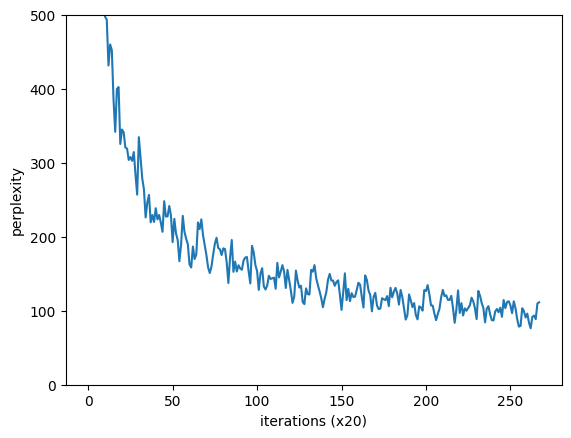

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  135.2529106978994


' 코드 부분 3 끝 '

In [7]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch06/train_rnnlm.py
License: MIT License
Accessed: 2024-11-22

Modified to work on jupyter notebook
------------------------------------------------------------
"""


# coding: utf-8
import sys
sys.path.append('..')
from optimizer import SGD
from trainer import RnnlmTrainer
from util import eval_perplexity
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

""" 코드 부분 1 시작 """
# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))
""" 코드 부분 1 끝 """

""" 코드 부분 2 시작 """
# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)
""" 코드 부분 2 끝 """


""" 코드 부분 3 시작 """
# 매개변수 저장
model.save_params()
""" 코드 부분 3 끝 """

## 6.5 RNNLM 추가 개선

### 6.5.1 LSTM 계층 다층화

LSTM 계층을 하나만 높는 것이 아니라, 여러 계층을 놓아서 성능을 높일 수 있다.

<img src="./deep_learning_2_images/fig 6-29.png" width="60%">

위 그림은 LSTM 계층을 두 개 쌓았다. 첫 번째 LSTM 계층의 출력이 두 번째 LSTM 계층의 입력으로 들어간다. Feed forward 신경망에서 계층을 쌓는 것과 동일한 효과이다.

몇 개의 층을 쌓을 지는 하이퍼파라미터이다. PTB 데이터셋에 대해서는 2~4 개의 층을 쌓으면 좋은 결과가 나온다고 알려져있다.

### 6.5.2 드롭아웃에 의한 과적합 억제

LSTM 계층을 다층화하면 표현력이 풍부한 모델을 만들 수는 있지만, 종종 overfitting 문제를 일으킨다. RNN은 일반적인 feed forward 신경망보다 overfitting 문제가 자주 발생한다.

overfitting을 억제하는 방법으로는 "훈련 데이터 양 늘리기", "모델의 복잡도 줄이기", "정규화" 등이 있었다. Dropout처럼 훈련 시 계층 내 뉴런을 무작위로 무시하고 학습하는 방법도 overfitting을 줄이기 위해 고안된 방법이다. 

LSTM 계층에 Dropout 계층을 넣을 때는, 시계열 방향 정보들(hidden state, memory cell)에 넣기보다는, 깊이에 따라 넣는 것이 좋을 수 있다. 시계열 방향 정보에 Dropout을 적용하면 노이즈가 누적되기 때문이다.

<img src="./deep_learning_2_images/fig 6-33.png" width="70%">

'일반적인 Dropout'은 시간 방향으로 적용하기 적합하지 않지만, 최근에는 시간방향으로도 Dropout을 적용하기 위한 시도들이 있다. **변형 드롭아웃** 또한 그 중 하나이다.

변형 드롭아웃은 같은 LSTM 계층끼리는 시간 방향에 대해서 같은 mask를 공유한다. 이러면 소실되는 정보가 고정되어서 시계열 정보가 점점 없어지는 현상을 막을 수 있다.

> mask는 데이터의 통과/차단을 결정하는 binary 형태의 무작위 패턴이다.

<img src="./deep_learning_2_images/fig 6-34.png" width="60%">

### 6.5.3 가중치 공유

**가중치 공유** 기법은 언어 모델을 개선하는 간단한 트릭 중 하나이다. 

<img src="./deep_learning_2_images/fig 6-35.png" width="60%">

위 그림을 보면, Embedding 계층과 Affine 계층이 서로 가중치를 공유하고 있다. 어휘 수가 $V$이고, hidden state의 차원 수가 $H$라고 하면, Embedding 계층의 가중치는 $V \times H$의 형상을 가지고, Affine 계층은 $H \times V$의 형상을 가지고 있다. 즉, Embedding 계층의 가중치를 transpose 한 뒤에 Affine 계층에 사용할수도 있다는 의미이다.

### 6.5.4 개선된 RNNLM 구현

<img src="./deep_learning_2_images/fig 6-36.png" width="30%">

개선점은 다음과 같다. 
- LSTM 계층의 다층화 (2층으로 만듬)
- Dropout 적용 (깊이 방향으로만)
- 가중치 공유 (Embedding 계층과 Affine 계층의 가중치 공유)

In [8]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch06/better_rnnlm.py
License: MIT License
Accessed: 2024-11-22

Modified to work on jupyter notebook
------------------------------------------------------------
"""

# coding: utf-8
import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
config.GPU = True
# ==============================================

# coding: utf-8
import sys
sys.path.append('..')
from time_layers import *
from np import *  # import numpy as np
from base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

여기서 TimeDropout 코드를 살펴보자

In [9]:
class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        # train 시에는 mask를 통한 Dropout 수행
        if self.train_flg:
            """ 
            입력 데이터와 똑같은 차원을 가지고, 무작위 값을 가진 np.array를 만든다.
            이후 dropout_ratio보다 큰 값을 가진 곳을 flg에 저장한다.
            flg에는 Dropout 되지 않는 곳에는 True가, Dropout 될 곳에는 False가 있다.
            scale은 Dropout 되지 않는 값들에 곱해질 값이다.
            """
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        # inference 시에는 그대로 통과
        else:
            return xs
    """ 
    Dropout 계층은 self.mask와 xs의 곱셈 노드로 볼 수 있다.
    그러면 xs 방향으로 나가는 기울기는 "들어온 기울기에 self.mask를 곱한 것"이 된다.  
    """
    def backward(self, dout):
        return dout * self.mask

학습을 진행해보자. 

In [10]:
"""
------------------------------------------------------------
Code Source:
URL: https://github.com/WegraLee/deep-learning-from-scratch-2/blob/master/ch06/train_better_rnnlm.py
License: MIT License
Accessed: 2024-11-22

Modified to work on jupyter notebook
------------------------------------------------------------
"""


from optimizer import SGD
from trainer import RnnlmTrainer
from util import eval_perplexity, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

Done
| 에폭 1 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 9999.99
| 에폭 1 |  반복 21 / 1327 | 시간 13[s] | 퍼플렉서티 3582.47
| 에폭 1 |  반복 41 / 1327 | 시간 26[s] | 퍼플렉서티 1845.71
| 에폭 1 |  반복 61 / 1327 | 시간 38[s] | 퍼플렉서티 1300.05
| 에폭 1 |  반복 81 / 1327 | 시간 51[s] | 퍼플렉서티 1021.61
| 에폭 1 |  반복 101 / 1327 | 시간 64[s] | 퍼플렉서티 820.52


KeyboardInterrupt: 

## 6.6 정리

이번 장에서는 다음 사항들을 살펴봤다.
- 게이트가 추가된 RNN
- 게이트가 추가된 RNN이 기울기 소실, 기울기 폭발 문제를 해결할 수 있다.
- LSTM 계층을 이용한 언어 모델
- PTB 데이터셋을 학습해 퍼플렉서티를 구해봤다.
- LSTM 다층화, 드롭아웃, 가중치 공유 등의 기법을 이용해 정확도를 향상시켜봤다.